<a href="https://colab.research.google.com/github/truc-h-nguyen/Toddler-activity-suggestions/blob/main/IoU_leakyrelu_sigmoid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip uninstall opencv-python-headless 
!pip install opencv-python-headless==4.1.2.30 
!pip install fiftyone
import fiftyone.zoo as foz
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from itertools import product
import os
import shutil
import glob
import random
import cv2
import re

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.python.keras.utils.data_utils import Sequence

import matplotlib.pyplot as plt

     |████████████████████████████████| 21.8 MB 1.3 MB/s 
     |████████████████████████████████| 1.3 MB 9.2 MB/s 
     |████████████████████████████████| 564 kB 50.5 MB/s 
     |████████████████████████████████| 29.2 MB 44 kB/s 
     |████████████████████████████████| 508 kB 43.9 MB/s 
     |████████████████████████████████| 55 kB 3.8 MB/s 
     |████████████████████████████████| 79.9 MB 125 kB/s 
     |████████████████████████████████| 13.2 MB 49.5 MB/s 
     |████████████████████████████████| 226 kB 58.3 MB/s 
     |████████████████████████████████| 645 kB 39.8 MB/s 
     |████████████████████████████████| 106 kB 53.9 MB/s 
     |████████████████████████████████| 132 kB 73.7 MB/s 
     |████████████████████████████████| 84 kB 3.6 MB/s 
     |████████████████████████████████| 68 kB 9.1 MB/s 
     |████████████████████████████████| 54 kB 4.4 MB/s 
     |████████████████████████████████| 79 kB 10.0 MB/s 
     |████████████████████████████████| 77 kB 7.7 MB/s 
     |████████████████████

In [ ]:
!pip install -U albumentations -q
import albumentations as A
import random

     |████████████████████████████████| 102 kB 14.8 MB/s 


In [ ]:
multi_set = foz.load_zoo_dataset(
    "coco-2017",
    split="train",
    label_types=["segmentations"],
    classes=["scissors", "bowl", "spoon", "hair drier", "bottle", "toothbrush", "apple"],
    max_samples=300,
)

 100% |██████|    1.9Gb/1.9Gb [7.7s elapsed, 0s remaining, 248.3Mb/s]       
Extracting annotations to '/root/fiftyone/coco-2017/raw/instances_train2017.json'
 100% |██████████████████| 300/300 [1.2m elapsed, 0s remaining, 4.2 images/s]      
Writing annotations for 300 downloaded samples to '/root/fiftyone/coco-2017/train/labels.json'
Dataset info written to '/root/fiftyone/coco-2017/info.json'
Loading 'coco-2017' split 'train'
 100% |█████████████████| 300/300 [6.7s elapsed, 0s remaining, 46.2 samples/s]       
Dataset 'coco-2017-train-300' created


In [ ]:
import cv2

In [ ]:
#Capture images and masks into a list
coco_masks = []
coco_imgs = [] 

#Stack masks for each class
for idx, sample in enumerate(multi_set):
  coco_img = sample['filepath']
  #coco_img = mpimg.imread(coco_img)
  coco_img = cv2.imread(coco_img)
  coco_img = cv2.cvtColor(coco_img, cv2.COLOR_BGR2RGB)
  coco_imgs.append(coco_img)

  useful_detections = [d for d in sample['ground_truth']['detections'] if d['label'] in ['bowl',"scissors", "bowl", "spoon", "hair drier", "bottle", "toothbrush", "apple"]]
  bbox = useful_detections[0]['bounding_box']
  x,y,w,h = bbox

  masks_one_image = np.zeros(coco_img.shape[:2]) #masks of each object in one image
  stacked_mask = np.zeros(coco_img.shape[:2]) #stacked all masks of one image regardless objects

  def possible_slices(x,w,y,h):
        xslices = [
                   slice(int(np.floor(x*coco_img.shape[1])), int(np.floor((x+w)*coco_img.shape[1]))),
                   slice(int(np.ceil(x*coco_img.shape[1])), int(np.floor((x+w)*coco_img.shape[1]))),
                   slice(int(np.floor(x*coco_img.shape[1])), int(np.ceil((x+w)*coco_img.shape[1]))),
                   slice(int(np.ceil(x*coco_img.shape[1])), int(np.ceil((x+w)*coco_img.shape[1]))),
        ]
        yslices = [
                   slice(int(np.floor(y*coco_img.shape[0])), int(np.floor((y+h)*coco_img.shape[0]))),
                   slice(int(np.ceil(y*coco_img.shape[0])), int(np.floor((y+h)*coco_img.shape[0]))),
                   slice(int(np.floor(y*coco_img.shape[0])), int(np.ceil((y+h)*coco_img.shape[0]))),
                   slice(int(np.ceil(y*coco_img.shape[0])), int(np.ceil((y+h)*coco_img.shape[0]))),
        ]
        return list(product(xslices,yslices))

  for detection in range(len(useful_detections)):
      bbox = useful_detections[detection]['bounding_box']
      x,y,w,h = bbox
      all_possible_slices = possible_slices(x,w,y,h)

      completed = False
      for xslice, yslice in all_possible_slices:
          if completed: continue
          try:
              masks_one_image[yslice, xslice] += useful_detections[detection]['mask']
              completed = True
              stacked_mask = cv2.bitwise_or(stacked_mask, masks_one_image)
          except:
              pass
  coco_masks.append(stacked_mask)

In [ ]:
#Set aside a validation split
val_samples = 60
train_imgs = coco_imgs[:-val_samples]
train_masks = coco_masks[:-val_samples]
val_imgs = coco_imgs[-val_samples:]
val_masks = coco_masks[-val_samples:]

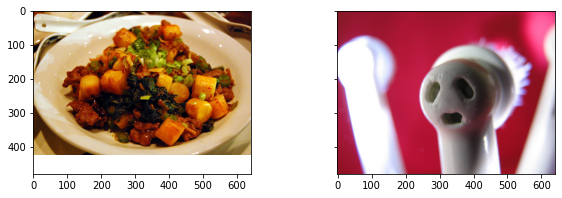

In [ ]:
fig, ax = plt.subplots(ncols =2, figsize = (10,3), sharex = True, sharey = True)
ax[0].imshow(train_imgs[14])
ax[1].imshow(val_imgs[14])

In [ ]:
#Resize image
img_size = 480
#Transform image
transform = A.Compose([
    A.Resize(img_size , img_size , p=1),
    A.HorizontalFlip(p=0.5),
    A.Blur(blur_limit=20,p=0.3),
    A.Sharpen(alpha=(0.2, 0.5), lightness=(0.5, 1.0), p=0.5),
    A.Transpose(p=0.4),
    ])

In [ ]:
class DataGenerator(keras.utils.Sequence):
  def __init__(self, input_img, input_mask, image_size, 
               augmentation, batch_size):
    self.image_size = img_size
    self.augmentation = augmentation
    self.batch_size = batch_size
    self.input_img = train_imgs
    self.input_mask = train_masks
    self.nb_y_features = 1 if len(train_masks[0].shape) == 2 else train_masks[0].shape[2]

  def __len__(self):
        return len(self.input_img) // self.batch_size

  def __getitem__(self, index):
     data_index_min = int(index*self.batch_size)
     data_index_max = int(min((index+1)*self.batch_size, len(self.input_img)))

     indexes = self.input_img[data_index_min:data_index_max]
     this_batch_size = len(indexes)
     
     X = np.empty((this_batch_size, self.image_size , self.image_size , 3), dtype=np.float32)
     y = np.empty((this_batch_size, self.image_size , self.image_size , self.nb_y_features), dtype=np.uint8)
     
     for i, sample_index in enumerate(indexes):
          X_sample = self.input_img[index * self.batch_size + i]
          y_sample = self.input_mask[index * self.batch_size + i]
          if self.augmentation is True:
              # Augmentation code
              #transformed_imgs, transformed_masks = transform(image=X_sample, mask = y_sample)
              #transformed_masks = transform(image=y_sample)
              #image_augm = transformed_imgs['image']
              #mask_augm = transformed_masks['mask'].reshape(self.image_size, self.image_size, self.nb_y_features)
              # divide by 255 to normalize images from 0 to 1
              #X[i, ...] = image_augm/255
              #y[i, ...] = mask_augm
              aug = transform(image = X_sample, mask = y_sample)
              img_aug = aug['image']
              mask_aug = aug['mask']
              X[i, ...] = img_aug/255
              y[i, ...] = mask_aug.reshape(self.image_size , self.image_size , self.nb_y_features).astype(np.uint8)
          else:
              pass
     return X, y

In [ ]:
train_generator = DataGenerator(input_img = train_imgs, input_mask = train_masks, image_size = img_size,
                                augmentation=True, batch_size = 5)
val_generator = DataGenerator(input_img = val_imgs, input_mask = val_masks, image_size = img_size,
                                augmentation=True, batch_size = 5)

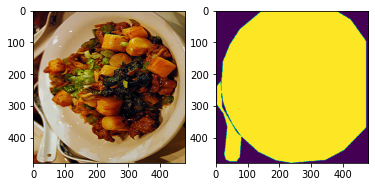

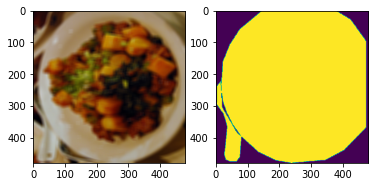

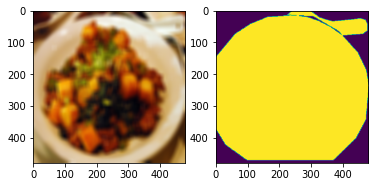

In [ ]:
for i in range(3):
  X_sample_temp, y_sample_temp = train_generator[2]
  fig, ax = plt.subplots(ncols=2)
  ax[0].imshow(X_sample_temp[4])
  ax[1].imshow(y_sample_temp[4,:,:,0])
  plt.show()

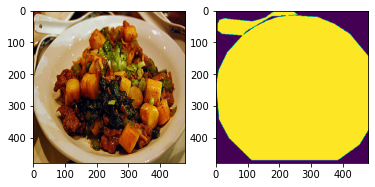

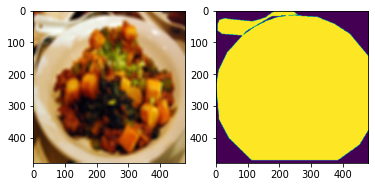

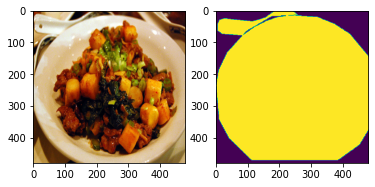

In [ ]:
for i in range(3):
  X_sample_temp, y_sample_temp = val_generator[2]
  fig, ax = plt.subplots(ncols=2)
  ax[0].imshow(X_sample_temp[4])
  ax[1].imshow(y_sample_temp[4,:,:,0])
  plt.show()

In [ ]:
from keras.layers import LeakyReLU

In [ ]:
#Image segmentation with a U-Net Xception-style model
def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("LeakyReLU")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("LeakyReLU")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("LeakyReLU")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("LeakyReLU")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("LeakyReLU")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="sigmoid", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


# Free up RAM in case the model definition cells were run multiple times
#keras.backend.clear_session()



[IoU](https://www.kaggle.com/cpmpml/fast-iou-metric-in-numpy-and-tensorflow)

In [ ]:
def get_iou_vector(A, B):
    # Numpy version
    
    batch_size = A.shape[0]
    metric = 0.0
    for batch in range(batch_size):
        t, p = A[batch], B[batch]
        true = np.sum(t)
        pred = np.sum(p)
        
        # deal with empty mask first
        if true == 0:
            metric += (pred == 0)
            continue
        
        # non empty mask case.  Union is never empty 
        # hence it is safe to divide by its number of pixels
        intersection = np.sum(t * p)
        union = true + pred - intersection
        iou = intersection / union
        
        # iou metrric is a stepwise approximation of the real iou over 0.5
        iou = np.floor(max(0, (iou - 0.45)*20)) / 10
        
        metric += iou
        
    # teake the average over all images in batch
    metric /= batch_size
    return metric


def my_iou_metric(label, pred):
    # Tensorflow version
    return tf.numpy_function(get_iou_vector, [label, pred > 0.5], tf.float64)

In [ ]:
# from keras import backend as K
# from tensorflow.python.ops.numpy_ops import np_config

# np_config.enable_numpy_behavior()
# def jaccard_coef(mask_true, mask_pred):
#   mask_true_fl = K.flatten(mask_true).astype(np.uint8)
#   mask_pred_fl = K.flatten(mask_pred).astype(np.uint8)
#   #sum of multiplication of flattened ground truth masks and predicted masks (1*1=1,1*0=0,...)
#   intersection = K.sum(mask_true_fl * mask_pred_fl)
#   #Plus 1 to avoid being undefined
#   return (intersection)/ (K.sum(mask_true_fl) + K.sum(mask_pred_fl) - intersection)

# def jaccard_coef_loss(mask_true, mask_pred):
#   return -jaccard_coef(mask_true, mask_pred) #minimize the value as loss function

In [ ]:
# Build model
model = get_model((img_size,img_size), 1)
# model.summary()
#Train model
# model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")
# model.compile(optimizer="adam", loss = 'binary_crossentropy')
#model.compile(optimizer="rmsprop", loss = 'binary_crossentropy')
#model.compile(optimizer="rmsprop", loss = jaccard_coef_loss)
model.compile(
  optimizer='adam',
  loss= "binary_crossentropy",
  metrics=([my_iou_metric], "mse", "acc"))

EPOCHS = 80
model_history = model.fit(
    train_generator,
    #validation_generator,
    epochs = EPOCHS,
    #batch_size = 5
)

Epoch 1/80
48/48 [==============================] - 33s 285ms/step - loss: 1.0415 - my_iou_metric: 0.0000e+00 - mse: 0.1323 - acc: 0.8485
Epoch 2/80
48/48 [==============================] - 14s 287ms/step - loss: 0.4132 - my_iou_metric: 0.0000e+00 - mse: 0.1016 - acc: 0.8876
Epoch 3/80
48/48 [==============================] - 14s 288ms/step - loss: 0.3209 - my_iou_metric: 8.3333e-04 - mse: 0.0869 - acc: 0.9026
Epoch 4/80
48/48 [==============================] - 14s 290ms/step - loss: 0.3265 - my_iou_metric: 8.3333e-04 - mse: 0.0896 - acc: 0.8948
Epoch 5/80
48/48 [==============================] - 14s 290ms/step - loss: 0.3518 - my_iou_metric: 0.0000e+00 - mse: 0.0960 - acc: 0.8940
Epoch 6/80
48/48 [==============================] - 14s 290ms/step - loss: 0.3066 - my_iou_metric: 0.0000e+00 - mse: 0.0843 - acc: 0.9044
Epoch 7/80
48/48 [==============================] - 14s 292ms/step - loss: 0.3137 - my_iou_metric: 0.0000e+00 - mse: 0.0869 - acc: 0.9029
Epoch 8/80
48/48 [================

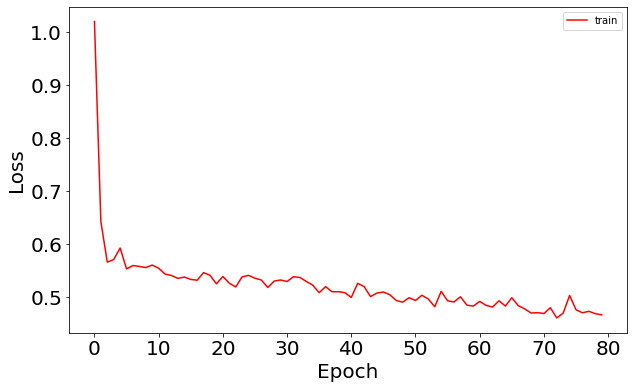

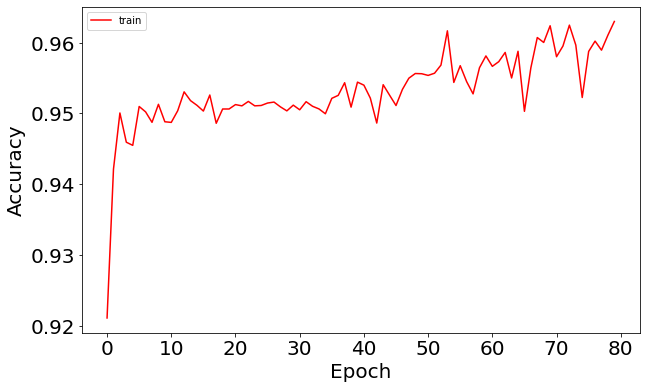

In [ ]:
# Plot the loss function
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(np.sqrt(model_history.history['loss']), 'r', label='train')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Loss', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)

# Plot the accuracy
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(np.sqrt(model_history.history['acc']), 'r', label='train')
ax.set_xlabel(r'Epoch', fontsize=20)
ax.set_ylabel(r'Accuracy', fontsize=20)
ax.legend()
ax.tick_params(labelsize=20)

In [ ]:
train_preds = model.predict(train_generator)

In [ ]:
np.unique(list(train_preds))

array([6.8052586e-08, 6.8103489e-08, 6.8536508e-08, ..., 9.9948406e-01,
       9.9979931e-01, 9.9980778e-01], dtype=float32)

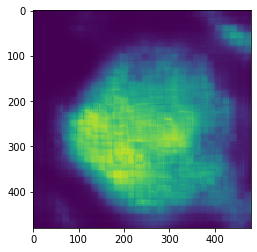

In [ ]:
plt.imshow(np.squeeze(train_preds[14]))

In [ ]:
#!ls drive/MyDrive

In [ ]:
os.getcwd()

'/content'

In [ ]:
!pip install mlflow --quiet

import mlflow
import os
from getpass import getpass

os.environ['MLFLOW_TRACKING_USERNAME'] = "***"
os.environ['MLFLOW_TRACKING_PASSWORD'] = "***"
os.environ['MLFLOW_TRACKING_PROJECTNAME'] = "***"

#mlflow.set_tracking_uri(f'https://dagshub.com/' + os.environ['MLFLOW_TRACKING_USERNAME'] + '/' + os.environ['MLFLOW_TRACKING_PROJECTNAME'] + '.mlflow')
mlflow.set_tracking_uri("sqlite:///drive/MyDrive/mlflow_db.sqlite")
    
with mlflow.start_run(run_name="MLflow on Colab"):
  mlflow.log_metric("m1", 2.0)
  mlflow.log_param("p1", "mlflow-colab")

In [ ]:
#sqlite:///drive/MyDrive/mlflow_db.sqlite
import pandas as pd
pd.read_sql_query("select * from sqlite_master", "sqlite:///drive/MyDrive/mlflow_db.sqlite")

In [ ]:
pd.read_sql_query("select * from metrics", "sqlite:///drive/MyDrive/mlflow_db.sqlite")

In [ ]:
# #Set aside a validation split
# val_samples = 20
# train_input_img= train_img[:-val_samples]
# train_target_mask = train_mask[:-val_samples]
# val_input_img = train_img[-val_samples:]
# val_target_mask = train_mask[-val_samples:]

# train_generator = DataGenerator(input_img = train_input_img, input_mask = train_target_mask, image_size = img_size,
#                                 augmentation=True, shuffle = False, batch_size = 5, seed = 40)
# validation_generator = DataGenerator(input_img = val_input_img, input_mask = val_target_mask, image_size = img_size,
#                                 augmentation=True, shuffle = False, batch_size = 5, seed = 40)

In [ ]:
# len(train_input_img),len(train_target_mask),len(val_input_img),len(val_target_mask)

In [ ]:
# #Same with train generator ?? 
# for i in range(5):
#   X_sample_temp, y_sample_temp = validation_generator[2]
#   fig, ax = plt.subplots(ncols=2)
#   ax[0].imshow(X_sample_temp[4])
#   ax[1].imshow(y_sample_temp[4,:,:,0])
#   plt.show()

In [ ]:
# opt = tf.keras.optimizers.Adam(learning_rate=0.1, clipnorm=1)
# model.compile(optimizer=opt, loss="binary_crossentropy")
# model.fit(
#     train_generator,
#     epochs = EPOCHS,
# )

In [ ]:
# model.compile(optimizer="adam", loss = [jaccard_coef_loss], metrics = [jaccard_coef])